## Import packages

In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector

colab = True
student = True

2024-10-08 22:42:19.740040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 22:42:19.748025: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 22:42:19.813376: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 22:42:19.875433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 22:42:19.925918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zero-pad each sequence a length ```max_review_length```

In [2]:
top_words = 5000
max_review_length = 100
INDEX_FROM = 3
embedding_vector_length = 32

## Import IMDB data

In [3]:
# --- Import the IMDB data and only consider the ``top_words``` most used words
np.load.__defaults__=(None, True, True, 'ASCII')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists.
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test```
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 

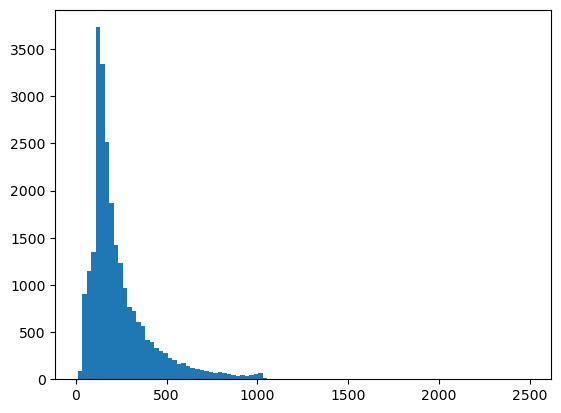

In [4]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [5]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [6]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [7]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [9]:
# --- truncate and pad input sequences

if student:
    # --- START CODE HERE (01)
    X_train = sequence.pad_sequences(X_train, maxlen=max_review_length, padding='post', truncating='post')
    X_test = sequence.pad_sequences(X_test, maxlen=max_review_length, padding='post', truncating='post')
    # --- END CODE HERE

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
    2   16]


# First model

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_01.png">

In the first model, we will simply
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence,
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [10]:
K.clear_session()

In [11]:
X_train[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223,    2,
         16], dtype=int32)

In [70]:
# --- create the model
# CODE-RNN1-2
if student:
    # --- START CODE HERE (02)
    # --- Using the Sequential API
    model = Sequential()
    model.add(Input(shape=(max_review_length,)))
    model.add(Embedding(top_words, embedding_vector_length))
    model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embedding_vector_length,)))
    model.add(Dense(1, activation='sigmoid'))
    # --- END CODE HERE

    # --- START CODE HERE (03)
    # --- Using the Functional API
    X = keras.Input(shape=(max_review_length,))
    E = Embedding(top_words, embedding_vector_length, input_length=max_review_length)(X)
    L = Lambda(lambda x: K.mean(x, axis=1))(E)
    Y = Dense(1, activation='sigmoid')(L)
    Model = Model(inputs=X, outputs=Y) 
    # --- END CODE HERE

print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,033 (625.13 KB)

 Trainable params: 160,033 (625.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [73]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6438 - loss: 0.6704 - val_accuracy: 0.7505 - val_loss: 0.5706
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7773 - loss: 0.5291 - val_accuracy: 0.7876 - val_loss: 0.4714
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8150 - loss: 0.4367 - val_accuracy: 0.8030 - val_loss: 0.4310


## Results

After only 3 epochs, you should obtain an accuracy around 83-84% for the test data.

In [1]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

NameError: name 'model' is not defined

## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [75]:
model.layers[0].get_weights()[0].shape

(5000, 32)

In [76]:
if student:
    # --- START CODE HERE (04)
    embedding_matrix = model.layers[0].get_weights()[0]
    great_id = word_to_id["great"]
    great_embedding = embedding_matrix[great_id]
    dist_v = np.linalg.norm(embedding_matrix - great_embedding, axis=1)
    # --- END CODE HERE
for i in np.argsort(dist_v)[0:20]: print(id_to_word[i])

great
excellent
wonderful
best
amazing
loved
superb
perfect
favorite
love
fantastic
enjoyed
wonderfully
fun
brilliant
touching
beautiful
today
heart
awesome


# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=128$

We will code this model
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [62]:
K.clear_session()

In [67]:
# --- create the model

if student:
    # --- START CODE HERE (05)
    # --- Using the Sequential API
    model = Sequential()
    model.add(Input(shape=(max_review_length,)))
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    # --- END CODE HERE

    # --- START CODE HERE (06)
    # --- Using the Functional API
    X = keras.Input(shape=(max_review_length,))
    E = Embedding(top_words, embedding_vector_length, input_length=max_review_length)(X)
    E = LSTM(128)(E)
    Y = Dense(1, activation='sigmoid')(E)
    model = Model(inputs=X, outputs=Y) 
    # --- END CODE HERE

print(model.summary())

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 100, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [68]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.5812 - loss: 0.6529 - val_accuracy: 0.7830 - val_loss: 0.4576
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.8344 - loss: 0.3997 - val_accuracy: 0.8094 - val_loss: 0.4411
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.8680 - loss: 0.3326 - val_accuracy: 0.8028 - val_loss: 0.4407


## Results

After only 3 epochs, you should obtain an accuracy around 84-85% for the test data.

In [69]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.28%
